In [1]:
import numpy as np
from google.colab import drive
import csv
import sklearn.model_selection
# makes printing more human-friendly
np.set_printoptions(precision=3,suppress=True)

#Function to process the dataset. Input the google drive path to the dataset as well as the percentage of train and test
#Function outputs the standardized train, test, val datasets and labels as well as the std and mean used to standardize
#Output is: X_train, y_train, X_val, y_val, X_test, y_test, mean, std
def process_dataset(path='SolPred/curated-solubility-dataset.csv', train_percentage=0.7, test_percentage=0.15, val_percentage=0.15):


  #Loads the database and takes out specific indices as labels and features. If changing dataset change those indexes
  def loaddataset(path):
      drive.mount('/content/drive/')
      with open('/content/drive/MyDrive/'+path, 'r') as f:
        l = csv.reader(f)
        data = np.array([list(filter(None,i)) for i in l])
        X = data[1:,9:-1]
        y = data[1:,5]
        return X.astype(np.double),y.astype(np.double)

  #Splits the data into training data, validation data, and testing data, and normalizes the data with respect to the training portion
  #Returns the X_train, y_train, X_val, y_val, X_test, y_val, train_mean, train_std
  def traintestsplit_and_normalize(train_p, test_p, val_p, features, labels):
    #Split data
    X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(features,labels, train_size = train_p, shuffle=True )
    X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size = val_p/(val_p+test_p))

    X_train = np.asfarray(X_train)
    X_val = np.asfarray(X_val)
    X_test = np.asfarray(X_test)

    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0)

    X_train = (X_train-X_mean)/X_std
    X_val = (X_val-X_mean)/X_std
    X_test = (X_test-X_mean)/X_std
    return X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std
  print('-----------------------------------------------------')

  print('loading dataset...')
  print('-----------------------------------------------------')

  X,y = loaddataset(path)

  #print(X[1])
  print('num_samples, num_features', X.shape)
  print('labels', y.shape)

  print('-----------------------------------------------------')
  print('Splitting dataset into train/test/val and normalizing')
  print('-----------------------------------------------------')

  X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std = traintestsplit_and_normalize(train_percentage,val_percentage,test_percentage,X,y)
  print("Training features mean: " + str(np.mean(X_train)) + ", std: " + str(np.std(X_train)) + ", shape: " + str(X_train.shape))
  print("Validation features mean: " + str(np.mean(X_val)) + ", std: " + str(np.std(X_val)) + ", shape: " + str(X_val.shape))
  print("Testing features mean: " + str(np.mean(X_test)) + ", std: " + str(np.std(X_test)) + ", shape: " + str(X_test.shape))

  return X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std

#Processes dataset with default values
X_train, y_train, X_val, y_val, X_test, y_test, mean, std = process_dataset()

-----------------------------------------------------
loading dataset...
-----------------------------------------------------
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
num_samples, num_features (9982, 19)
labels (9982,)
-----------------------------------------------------
Splitting dataset into train/test/val and normalizing
-----------------------------------------------------
Training features mean: -8.085017509980335e-16, std: 1.000000000000001, shape: (6987, 19)
Validation features mean: 0.0005016669533454465, std: 0.943511019936938, shape: (1497, 19)
Testing features mean: -0.001834741035273268, std: 0.9463032341413049, shape: (1498, 19)


In [2]:
import random
import torch

def data_iter(batch_size, features, labels):
  num_samples = len(features)
  indices = list(range(num_samples))
  random.shuffle(indices)

  for i in range(0, num_samples, batch_size):
    X, y = [],[]
    for j in indices[i:i+batch_size]:
      X.append(torch.from_numpy(features[j]))
      y.append(torch.from_numpy(np.array(labels[j])))
    yield torch.stack(X), torch.stack(y)

for X_batch, y_batch in data_iter(10, X_train,y_train):
  print('X_batch', X_batch.shape, X_batch.dtype)
  print('y_batch', y_batch.shape, y_batch.dtype)
  break

X_batch torch.Size([10, 19]) torch.float64
y_batch torch.Size([10]) torch.float64


In [3]:
from torch import nn
class LinearANN(nn.Module):
  def __init__(self, input_dim):
        super(LinearANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.softmax = nn.Softmax(dim=1)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.double()

  def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

#Check model:
model = LinearANN(len(X_train[0]))

for X_batch, y_batch in data_iter(16, X_train, y_train):
    out_batch = model(X_batch)
    print('X_batch', X_batch.shape)
    print('out_batch', out_batch.shape)
    break

X_batch torch.Size([16, 19])
out_batch torch.Size([16, 1])


In [4]:
LEARNING_RATE = 0.0001
#Training:
import torch.optim as optim

lossf = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
from scipy.optimize._lsq.trf_linear import make_strictly_feasible
#Training parameters
n_epochs = 100
batch_size = 10
batch_start = torch.arange(0,len(X_train),batch_size)

#For keeping track of best
best_mse = np.inf
best_weights = None
history = []

import tqdm
import copy
#Inspiration from https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
for epoch in range(n_epochs):
  model.train()
  with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
    bar.set_description(f"Epoch {epoch}")
    for X_batch, y_batch in data_iter(batch_size, X_train, y_train):
      y_pred = model(X_batch)
      loss = lossf(y_pred, y_batch.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      bar.set_postfix(mse=float(loss))
  model.eval()
  y_pred = model(torch.from_numpy(X_val))
  mse = lossf(y_pred,torch.from_numpy(y_val).unsqueeze(1))
  history.append(float(mse))
  if (mse < best_mse):
    print(mse.item())
    best_mse = mse
    best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)

tensor(4.3279, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(2.5810, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.9694, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.7514, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.6194, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.6119, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.4945, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.4737, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.4202, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.3833, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.3742, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.3583, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.3202, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.2555, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.2372, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.1932, dtype=torch.float64, grad

<All keys matched successfully>

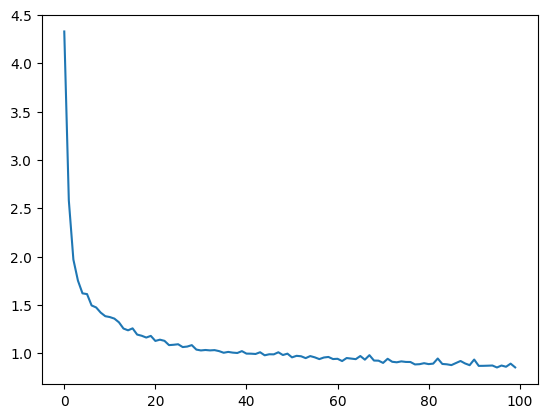

In [6]:
import matplotlib.pyplot as plt

plt.plot(history)

In [7]:
#Test results:
y_pred = model(torch.from_numpy(X_test))
mse = lossf(y_pred,torch.from_numpy(y_test).unsqueeze(1))
print("MSE: " + str(mse.item()) + ", RMSE: " + str(torch.sqrt(mse).item()))

MSE: 0.7258515626966532, RMSE: 0.8519692263788952
